In [1]:
import torch
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
from matplotlib.patches import Rectangle
import os 

In [2]:
# loading climatologies

prism = xr.open_dataset('C:/Users/SBEALE/Desktop/full_domain/prec_01_PRISM_Daymet.nc')
wrf = xr.open_dataset('C:/Users/SBEALE/Desktop/full_domain/prec_01_WRF_coarse.nc')
coast = xr.open_dataset('C:/Users/SBEALE/Desktop/full_domain/coast.nc')
dem = xr.open_dataset('C:/Users/SBEALE/Desktop/full_domain/DEM.nc')
lat = xr.open_dataset('C:/Users/SBEALE/Desktop/full_domain/lat.nc')
lon = xr.open_dataset('C:/Users/SBEALE/Desktop/full_domain/lon.nc')


In [3]:
prism_coarse = xr.open_mfdataset('C:/Users/SBEALE/Desktop/full_domain/prism_coarse.nc')
landsea_wc = xr.open_mfdataset('C:/Users/SBEALE/Desktop/full_domain/WorldClim_mask_coarse.nc')

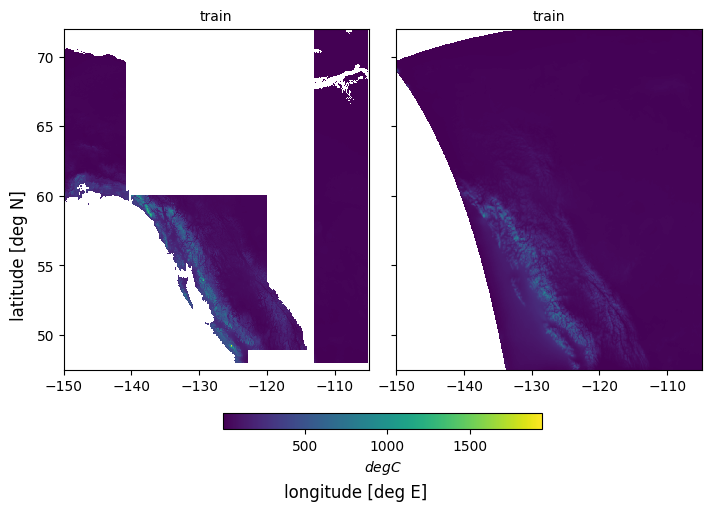

In [4]:
fig, ax = plt.subplots(1, 2, layout='constrained', figsize=(7, 5), sharex=True, sharey=True)

pc1 = ax[0].pcolormesh(prism.longitude, prism.latitude, prism.prec, vmin=np.nanmin(prism.prec), vmax=np.nanmax(prism.prec), cmap='viridis', label=r'$m$')
ax[0].set_title(f'train', fontsize='medium', loc='center')

pc1 = ax[1].pcolormesh(wrf.longitude, wrf.latitude, wrf.prec, vmin=np.nanmin(prism.prec), vmax=np.nanmax(prism.prec), cmap='viridis', label=r'$m$')
ax[1].set_title(f'train', fontsize='medium', loc='center')

fig.supylabel('latitude [deg N]')
fig.supxlabel('longitude [deg E]')

fig.colorbar(pc1, shrink=0.5, aspect=20, location='bottom', ax=ax[0:2], label=r'$deg C$')

In [5]:
# cropping to BC prism 

wrf = wrf.sel(longitude=slice(-140, -105), latitude=slice(57, 47.8))
prism = prism.sel(longitude=slice(-140, -105), latitude=slice(57, 47.8))
prism_coarse = prism_coarse.sel(longitude=slice(-140, -105), latitude=slice(57, 47.8))
landsea_wc = landsea_wc.sel(longitude=slice(-140, -105), latitude=slice(57, 47.8))
dem = dem.sel(longitude=slice(-140, -105), latitude=slice(57, 47.8))
lat = lat.sel(longitude=slice(-140, -105), latitude=slice(57, 47.8))
lon = lon.sel(longitude=slice(-140, -105), latitude=slice(57, 47.8))
coast = coast.sel(longitude=slice(-140, -105), latitude=slice(57, 47.8))

In [6]:
wrf_tens = torch.from_numpy(np.array(wrf.prec))
prism_tens = torch.from_numpy(np.array(prism.prec))
prism_coarse_tens = torch.from_numpy(np.array(prism_coarse.tmax))
dem_tens = torch.from_numpy(np.array(dem.dem))
lat_tens = torch.from_numpy(np.array(lat.lat))
lon_tens = torch.from_numpy(np.array(lon.lon))
coast_tens = torch.from_numpy(np.array(coast.dist))

In [7]:
wrf_tens = wrf_tens.where(np.isnan(prism_coarse_tens)==False, np.nan)
dem_tens = dem_tens.where(np.isnan(prism_tens)==False, np.nan)
lat_tens = lat_tens.where(np.isnan(prism_tens)==False, np.nan)
lon_tens = lon_tens.where(np.isnan(prism_tens)==False, np.nan)
coast_tens = coast_tens.where(np.isnan(prism_tens)==False, np.nan)

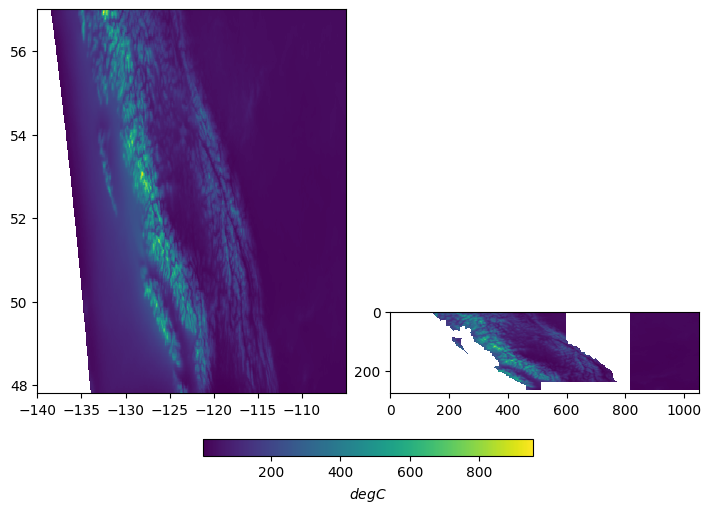

In [8]:
fig, ax = plt.subplots(1, 2, layout='constrained', figsize=(7, 5))

pc1 = ax[0].pcolormesh(wrf.longitude, wrf.latitude, wrf.prec, cmap='viridis', label=r'$m$')
pc2 = ax[1].imshow(wrf_tens, cmap='viridis', label=r'$m$')


fig.colorbar(pc1, shrink=0.5, aspect=20, location='bottom', ax=ax[0:2], label=r'$deg C$')

In [9]:
prism_prec = prism['prec']
wrf_prec = wrf['prec']
coast_dist = coast['dist']
dem_dem = dem['dem']
lat_lat = lat['lat']
lon_lon = lon['lon']

In [10]:
prism_mean = np.nanmean(prism_tens)
wrf_mean = np.nanmean(wrf_tens)
coast_mean = np.nanmean(coast_tens)
dem_mean = np.nanmean(dem_tens)
lat_mean = np.nanmean(lat_tens)
lon_mean = np.nanmean(lon_tens)

In [11]:
# calculating standard deviation 

prism_std = np.nanstd(prism_tens)
wrf_std = np.nanstd(wrf_tens)
coast_std = np.nanstd(coast_tens)
dem_std = np.nanstd(dem_tens)
lat_std = np.nanstd(lat_tens)
lon_std = np.nanstd(lon_tens)

In [12]:
import csv 
# standardization is done based on mean and standard deviation of training data
# training data is normalized using that mean and std
# data rows as dictionary objects 
mydict =[{'var': 'prec','clim': 'prism', 'mean': prism_mean, 'std':prism_std}, 
         {'var': 'prec', 'clim': 'wrf', 'mean': wrf_mean, 'std':wrf_std}, 
         {'var': 'dist from coast', 'clim': 'prism', 'mean':coast_mean, 'std':coast_std},
         {'var': 'dem', 'clim': 'prism', 'mean':dem_mean, 'std':dem_std},
         {'var': 'lat', 'clim': 'prism', 'mean':lat_mean, 'std':lat_std},
         {'var': 'lon', 'clim': 'prism', 'mean':lon_mean, 'std':lon_std},
         ]

# field names 
fields = ['var', 'clim', 'mean', 'std'] 

with open('C:/Users/SBEALE/Desktop/operational/prec/jan/wrf_train_shift16/standardization.csv', 'w', newline='') as file: 
    
    writer = csv.DictWriter(file, fieldnames = fields)

    writer.writeheader() 

    writer.writerows(mydict)

In [13]:
# standardizing all variables 
prism['prec'] = (prism_prec - prism_mean)/prism_std
wrf['prec'] = (wrf_prec - wrf_mean)/wrf_std
coast['dist'] = (coast_dist - coast_mean)/coast_std
dem['dem'] = (dem_dem - dem_mean)/dem_std
lat['lat'] = (lat_lat - lat_mean)/lat_std
lon['lon'] = (lon_lon - lon_mean)/lon_std

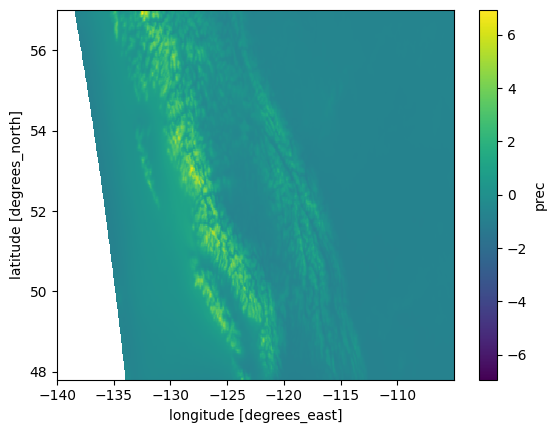

In [14]:
wrf.prec.plot(cmap='viridis')

In [15]:
prism.prec.to_netcdf('C:/Users/SBEALE/Desktop/operational/prec/jan/wrf_train_shift16/prism_train.nc')
wrf.prec.to_netcdf('C:/Users/SBEALE/Desktop/operational/prec/jan/wrf_train_shift16/wrf_train.nc')
landsea_wc.mask.to_netcdf('C:/Users/SBEALE/Desktop/operational/prec/jan/wrf_train_shift16/wrf_mask_train.nc')
dem.dem.to_netcdf('C:/Users/SBEALE/Desktop/operational/prec/jan/wrf_train_shift16/dem_train.nc')
lat.lat.to_netcdf('C:/Users/SBEALE/Desktop/operational/prec/jan/wrf_train_shift16/lat_train.nc')
lon.lon.to_netcdf('C:/Users/SBEALE/Desktop/operational/prec/jan/wrf_train_shift16/lon_train.nc')
coast.dist.to_netcdf('C:/Users/SBEALE/Desktop/operational/prec/jan/wrf_train_shift16/coast_train.nc')

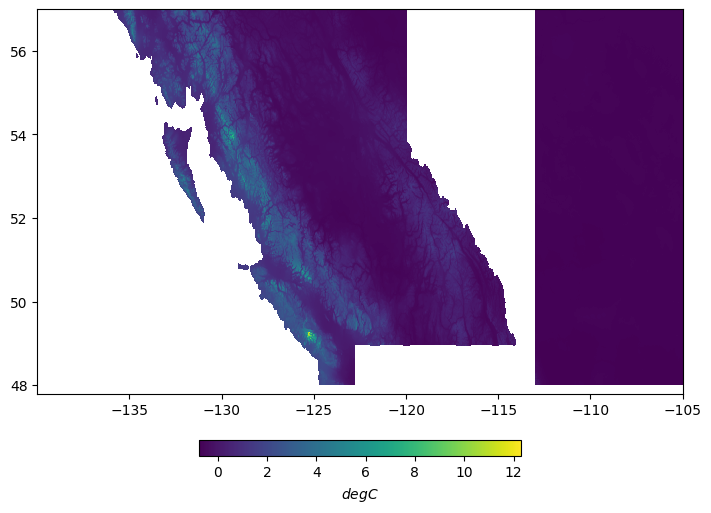

In [16]:
x = xr.open_dataset('C:/Users/SBEALE/Desktop/operational/prec/jan/wrf_train_shift16/prism_train.nc')

fig, ax = plt.subplots(1, 1, layout='constrained', figsize=(7, 5), sharex=True, sharey=True)

pc1 = ax.pcolormesh(x.longitude, x.latitude, x.prec, cmap='viridis', label=r'$m$')

# ax.set_ylim(50,51)
# ax.set_xlim(-125,-124)

fig.colorbar(pc1, shrink=0.5, aspect=20, location='bottom', label=r'$deg C$')

In [17]:
prism_pt = np.array(prism.prec)
wrf_pt = np.array(wrf.prec)
landsea_pt = np.array(landsea_wc.mask)
coast_pt = np.array(coast.dist)
dem_pt = np.array(dem.dem)
lat_pt = np.array(lat.lat)
lon_pt = np.array(lon.lon)

In [18]:
dem_pt.shape

(1104, 4200)

In [19]:
wrf_pt.shape

(276, 1050)

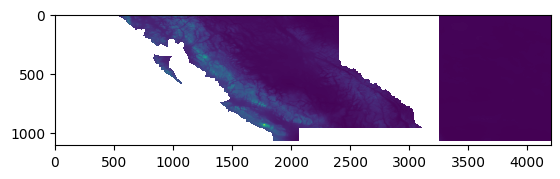

In [20]:
plt.imshow(prism_pt, cmap='viridis')

## making tiles for prism and daymet janarately 
## nan values should janarate them 
## prism will shift by 16 
## daymet by 64 

In [20]:
x_fine = np.arange(0,prism_pt.shape[0]-128, 16)
y_fine = np.arange(0,prism_pt.shape[1]-128, 16)

x_coarse = np.arange(0,wrf_pt.shape[0]-32, 4)
y_coarse = np.arange(0,wrf_pt.shape[1]-32, 4)

tiles_fine_prism = []
tiles_fine_coast = []
tiles_fine_dem = []
tiles_fine_lat = []
tiles_fine_lon = []
for i in range(0, len(y_fine)):
    prism = prism_pt[:,0+y_fine[i]:128+y_fine[i]]
    coast = coast_pt[:,0+y_fine[i]:128+y_fine[i]]
    dem = dem_pt[:,0+y_fine[i]:128+y_fine[i]]
    lat = lat_pt[:,0+y_fine[i]:128+y_fine[i]]
    lon = lon_pt[:,0+y_fine[i]:128+y_fine[i]]
    for j in range(0, len(x_fine)):
        tiles_fine_prism.append(prism[0+x_fine[j]:128+x_fine[j]])
        tiles_fine_coast.append(coast[0+x_fine[j]:128+x_fine[j]])
        tiles_fine_dem.append(dem[0+x_fine[j]:128+x_fine[j]])
        tiles_fine_lat.append(lat[0+x_fine[j]:128+x_fine[j]])
        tiles_fine_lon.append(lon[0+x_fine[j]:128+x_fine[j]])
        
tiles_coarse_wrf = []
tiles_coarse_landsea = []
for i in range(0, len(y_coarse)):
    wrf = wrf_pt[:,0+y_coarse[i]:32+y_coarse[i]]
    landsea = landsea_pt[:,0+y_coarse[i]:32+y_coarse[i]]
    for j in range(0, len(x_fine)):
        tiles_coarse_wrf.append(wrf[0+x_coarse[j]:32+x_coarse[j]])
        tiles_coarse_landsea.append(landsea[0+x_coarse[j]:32+x_coarse[j]])

In [21]:
len(tiles_fine_prism)

15555

In [22]:
len(tiles_fine_dem)

15555

In [23]:
len(tiles_coarse_wrf)

15555

In [24]:
x = prism_pt[2000:2500,2000:2500]

C:\Users\SBEALE\AppData\Local\Temp\ipykernel_25388\1468958611.py:1: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(x[0:128, 0:128])


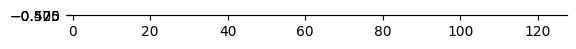

In [25]:
plt.imshow(x[0:128, 0:128])

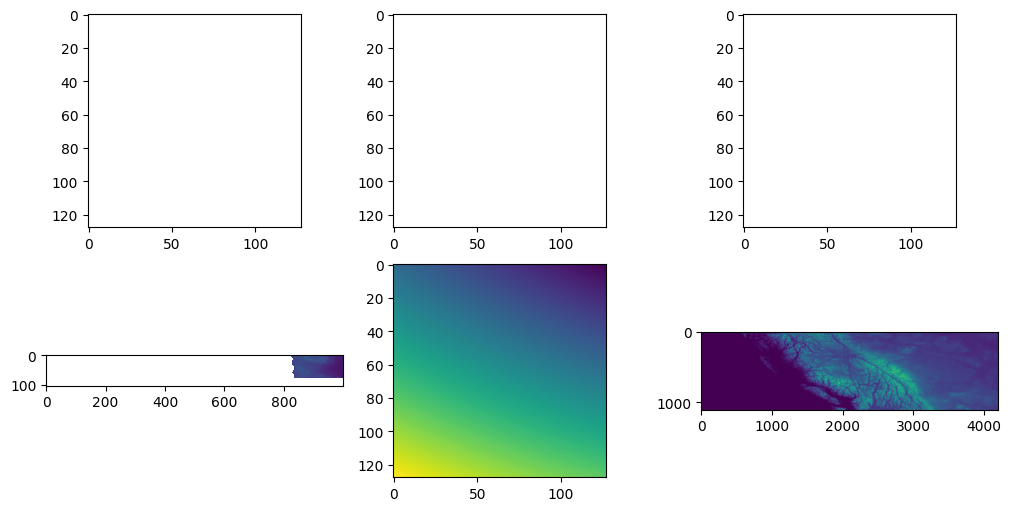

In [26]:
i = 2550
fig, ax = plt.subplots(2, 3, layout='constrained', figsize=(10, 5))

pc1 = ax[0,0].imshow(tiles_fine_prism[i], vmin=np.nanmin(prism_pt), vmax=np.nanmax(prism_pt))
pc1 = ax[0,1].imshow(tiles_fine_prism[i+5], vmin=np.nanmin(prism_pt), vmax=np.nanmax(prism_pt))
pc1 = ax[0,2].imshow(tiles_fine_prism[i+10], vmin=np.nanmin(prism_pt), vmax=np.nanmax(prism_pt))

pc1 = ax[1,1].imshow(np.nan_to_num(tiles_fine_coast[i], nan=np.nanmean(tiles_fine_coast[i])))
pc3 = ax[1,0].imshow(prism_pt[1000:1500,1000:2000], vmin=np.nanmin(prism_pt), vmax=np.nanmax(prism_pt))
pc4 = ax[1,2].imshow(dem_pt)

In [27]:
size_fine = 128*128
size_coarse = 32*32

good_tiles_prism = []
good_tiles_dem = []
good_tiles_coast = []
good_tiles_lat = []
good_tiles_lon = []

good_tiles_wrf = []
good_tiles_landsea = []

for i in range(0, len(tiles_fine_prism)):
    ind = np.argwhere(np.isnan(tiles_fine_prism[i]))
    percent_nan_prism = ind.shape[0]/size_fine *100
    ind = np.argwhere(np.isnan(tiles_coarse_wrf[i]))
    percent_nan_wrf = ind.shape[0]/size_coarse *100
    if ((percent_nan_prism == 0) & (percent_nan_wrf==0)):
        good_tiles_prism.append(tiles_fine_prism[i])
        good_tiles_dem.append(tiles_fine_dem[i])
        good_tiles_coast.append(tiles_fine_coast[i])
        good_tiles_lat.append(tiles_fine_lat[i])
        good_tiles_lon.append(tiles_fine_lon[i])
        
        good_tiles_wrf.append(tiles_coarse_wrf[i])
        good_tiles_landsea.append(tiles_coarse_landsea[i])
        

In [28]:
len(good_tiles_dem)

7166

In [29]:
len(good_tiles_prism)

7166

In [30]:
import gc

tiles_unsq = [x.unsqueeze(0) for x in torch.as_tensor(np.array(good_tiles_prism))]
good_tiles_prism = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

torch.save(good_tiles_prism, 'C:/Users/SBEALE/Desktop/operational/prec/jan/wrf_train_shift16/prism_train.pt')

del good_tiles_prism
del x
del tiles_unsq

gc.collect()

3

In [31]:
tiles_unsq = [x.unsqueeze(0) for x in torch.as_tensor(np.array(good_tiles_wrf))]
good_tiles_wrf = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

tiles_unsq = [x.unsqueeze(0) for x in torch.as_tensor(np.array(good_tiles_landsea))]
good_tiles_landsea = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

x = torch.cat((good_tiles_wrf, good_tiles_landsea), dim=1)

torch.save(x, 'C:/Users/SBEALE/Desktop/operational/prec/jan/wrf_train_shift16/wrf_train.pt')

# del good_tiles_wrf
# del x
# del good_tiles_landsea
# del tiles_unsq

# gc.collect()

In [32]:
x.shape

torch.Size([7166, 2, 32, 32])

In [33]:
tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_dem))]
good_tiles_dem = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

del tiles_unsq

tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_coast))]
good_tiles_coast = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

del tiles_unsq

tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_lat))]
good_tiles_lat = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

del tiles_unsq

tiles_unsq = [x.unsqueeze(0) for x in torch.from_numpy(np.array(good_tiles_lon))]
good_tiles_lon = torch.cat(tiles_unsq, dim = 0).unsqueeze(1)

del tiles_unsq

In [34]:
x = torch.cat((good_tiles_dem, good_tiles_lat, good_tiles_lon, good_tiles_coast), dim=1)

In [35]:
x.shape

torch.Size([7166, 4, 128, 128])

In [36]:
torch.save(x, 'C:/Users/SBEALE/Desktop/operational/prec/jan/wrf_train_shift16/HR_covariates_train.pt')

del x 
del good_tiles_dem
del good_tiles_lat
del good_tiles_lon
del good_tiles_coast

gc.collect()

0